In [24]:
import pandas as pd

#Dataframe definieren
df = pd.read_csv("data_randomized.csv", sep=";", encoding="ansi")
# Deine bestehenden Mappings für ordinale Features
ordinal_cols_mapping = [
    {"col": "Alter", "mapping": {
        'Unter 18': 0, '18-24': 1, '25-30': 2, '31-40': 3,
        '41-50': 4, '51-60': 5, 'Über 60': 6
    }},
    {"col": "Betriebszugehoerigkeit", "mapping": {
        '0-2': 0, '"3-5"': 1, '"6-8"': 2, '"9-11"': 3, '"12-14"': 4,
        '15-17': 5, '18-20': 6, '21-23': 7, '24-26': 8,
        '27-29': 9, '30-32': 10, '33-35': 11, '36-38': 12,
        '39-41': 13, '42-44': 14, '45-47': 15, '48-50': 16
    }},
    {"col": "Zeit_auf_Position", "mapping": {
        '0-2': 0, '"3-5"': 1, '"6-8"': 2, '"9-11"': 3, '"12-14"': 4,
        '15-17': 5, '18-20': 6
    }},
    {"col": "2023_Ziele", "mapping": {
        'Unrated': 0, 'Unterdurchschnitt': 1,
        'Durchschnitt': 2, 'Überdurchschnitt': 3
    }},
    {"col": "2023_Pers_Beurteilung", "mapping": {
        'Unrated': 0, 'Unterdurchschnitt': 1,
        'Durchschnitt': 2, 'Überdurchschnitt': 3
    }},
    {"col": "2024_Ziele", "mapping": {
        'Unrated': 0, 'Unterdurchschnitt': 1,
        'Durchschnitt': 2, 'Überdurchschnitt': 3
    }},
    {"col": "2024_Pers_Beurteilung", "mapping": {
        'Unrated': 0, 'Unterdurchschnitt': 1,
        'Durchschnitt': 2, 'Überdurchschnitt': 3
    }},
    {"col": "Krankenstand_2023", "mapping": {
        'kleiner 1%': 0, '1,0 - 3%': 1, '3,1 - 5%': 2,
        '5,1% - 10%': 3, '10,1% - 15%': 4, '15,1 - 20%': 5,
        '20,01 - 40%': 6, '40,01 - 60 %': 7,
        '60,01 - 75%': 8, '75,01 - 100 %': 9
    }},
    {"col": "Krankenstand_2024", "mapping": {
        'kleiner 1%': 0,'1,0 - 3%': 1, '3,1 - 5%': 2,
        '5,1% - 10%': 3, '10,1% - 15%': 4, '15,1 - 20%': 5,
        '20,01 - 40%': 6, '40,01 - 60 %': 7,
        '60,01 - 75%': 8, '75,01 - 100 %': 9
    }},
    {"col": "Gehaltsentwicklung", "mapping": {
        '"-100%-96%"': 0, '"-95%-91%"': 1, '"-90%-86%"': 2,
        '"-85%-81%"': 3, '"-80%-76%"': 4, '"-75%-71%"': 5,
        '"-70%-66%"': 6, '"-65%-61%"': 7, '"-60%-56%"': 8,
        '"-55%-51%"': 9, '"-50%-46%"': 10, '"-45%-41%"': 11,
        '"-40%-36%"': 12, '"-35%-31%"': 13, '"-30%-26%"': 14,
        '"-25%-21%"': 15, '"-20%-16%"': 16, '"-15%-11%"': 17,
        '"-10%-6%"': 18, '"-5%-1%"': 19, '0%-4%': 20,
        '5%-9%': 21, '10%-14%': 22, '15%-19%': 23,
        '20%-24%': 24, '25%-29%': 25, '30%-34%': 26,
        '35%-39%': 27, '40%-44%': 28, '45%-49%': 29,
        '50%-54%': 30, '55%-59%': 31, '60%-64%': 32,
        '65%-69%': 33, '70%-74%': 34, '75%-79%': 35,
        '80%-84%': 36, '85%-89%': 37, '90%-94%': 38,
        '95%-100%': 39
    }}
]

# Nominale Features (ohne natürliche Ordnung)
nominal_cols = ["Geschlecht", "Bereich", "FTE","FK"]

def apply_ordinal_encoding(df: pd.DataFrame) -> pd.DataFrame:
    df_encoded = df.copy()

    # Liste der zu behaltenden Spalten
    target_cols = [item["col"] for item in ordinal_cols_mapping]
    keep_cols = target_cols + nominal_cols + ["Aktiv"]
    df_encoded = df_encoded[[col for col in keep_cols if col in df_encoded.columns]]

    # --- Ordinale Codierung ---
    for item in ordinal_cols_mapping:
        col = item["col"]
        mapping = item["mapping"]

        if col in df_encoded.columns:
            df_encoded[f"{col}_vorhanden"] = df_encoded[col].notna().astype(int)
            df_encoded[col] = df_encoded[col].astype(str).map(mapping)
            df_encoded[col] = df_encoded[col].fillna(-1)
            df_encoded[col] = df_encoded[col].replace("nan", -1)
            df_encoded[col] = df_encoded[col].astype(int)
    # Konstante Spalten entfernen
    constant_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() == 1]
    df_encoded = df_encoded.drop(columns=constant_cols)
    # --- One-Hot-Encoding für nominale Features ---
    for col in nominal_cols:
        if col in df_encoded.columns:
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=False)
            # Boolean → int
            dummies = dummies.astype(int)
            df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)

    # Zielspalte
    if "Aktiv" in df_encoded.columns:
        df_encoded["Aktiv"] = df_encoded["Aktiv"].astype(int)

    return df_encoded




In [25]:
# Neue Funktion für Feature Selection mit LightGBM + kategorischen Features
import pandas as pd
import lightgbm as lgb
from sklearn.feature_selection import RFE, SelectKBest, f_classif

def feature_selection(df: pd.DataFrame, method="rfe", k=5, random_state: int = 42):
    X = df.drop("Aktiv", axis=1).copy()
    y = df["Aktiv"]

    if method == "rfe":
        # Für RFE brauchen wir numerische Arrays → Codes nutzen
        X_num = X.copy()
        for col in X_num.select_dtypes(include="category").columns:
            X_num[col] = X_num[col].cat.codes

        model = lgb.LGBMClassifier(random_state=random_state)
        selector = RFE(model, n_features_to_select=k)
        selector = selector.fit(X_num, y)
        selected_features = X_num.columns[selector.support_]

    elif method == "kbest":
        # Auch KBest braucht numerisch
        X_num = X.copy()
        for col in X_num.select_dtypes(include="category").columns:
            X_num[col] = X_num[col].cat.codes

        selector = SelectKBest(score_func=f_classif, k=k)
        selector.fit(X_num, y)
        selected_features = X_num.columns[selector.get_support()]

    elif method == "importance":
        # LightGBM kann direkt mit category umgehen
        model = lgb.LGBMClassifier(random_state=random_state)
        cat_feats = [c for c in X.columns if str(X[c].dtype) == "category"]
        model.fit(X, y, categorical_feature=cat_feats)
        importances = pd.Series(model.feature_importances_, index=X.columns)
        selected_features = importances.sort_values(ascending=False).head(k).index

    else:
        raise ValueError("Methode muss 'rfe', 'kbest' oder 'importance' sein.")

    return df[selected_features.tolist() + ["Aktiv"]], selected_features

In [26]:
# Daten einlesen und kodieren
df_encoded = apply_ordinal_encoding(df)

In [27]:
df_encoded.describe()

,Alter,Betriebszugehoerigkeit,Zeit_auf_Position,2023_Ziele,2023_Pers_Beurteilung,2024_Ziele,2024_Pers_Beurteilung,Krankenstand_2023,Krankenstand_2024,Gehaltsentwicklung,...,Geschlecht_M,Bereich_Geschäftsbereich,Bereich_HQ,Bereich_Werk,FTE_0.0,FTE_0.5,FTE_1.0,FTE_999.0,FK_0,FK_1
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,...,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,3.590379,4.448980,1.470845,0.262391,0.555394,0.137755,0.381195,-0.386297,-0.508746,12.821429,...,0.774781,0.325802,0.247085,0.427114,0.255831,0.250729,0.263848,0.229592,0.487609,0.512391
std,1.394423,3.990454,1.812074,1.653310,1.739990,1.620655,1.670448,1.726623,1.229024,11.589227,...,0.417879,0.468845,0.431474,0.494839,0.436486,0.433591,0.440879,0.420724,0.500029,0.500029
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,21.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,7.000000,2.000000,2.000000,2.000000,2.000000,2.000000,-1.000000,-1.000000,22.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,6.000000,15.000000,6.000000,3.000000,3.000000,3.000000,3.000000,9.000000,9.000000,39.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df_encoded['Gehaltsentwicklung_vorhanden'].mean()

0.5998542274052479

In [29]:
# Teste RFE
df_rfe, features_rfe = feature_selection(df_encoded, method="rfe", k=10)
print("RFE Features:", list(features_rfe))

# Teste KBest
df_kbest, features_kbest = feature_selection(df_encoded, method="kbest", k=10)
print("KBest Features:", list(features_kbest))

# Teste Importance
df_imp, features_imp = feature_selection(df_encoded, method="importance", k=10)
print("Importance Features:", list(features_imp))

# For notebook output, you can also display as DataFrame:
import pandas as pd
pd.DataFrame({
    "RFE": list(features_rfe),
    "KBest": list(features_kbest),
    "Importance": list(features_imp)
})

[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487609 -> initscore=-0.049573
[LightGBM] [Info] Start training from score -0.049573
[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 23
[LightGBM] [Info] [binary:Boos

,RFE,KBest,Importance
0,Alter,Alter,Betriebszugehoerigkeit
1,Betriebszugehoerigkeit,Betriebszugehoerigkeit,Gehaltsentwicklung
2,Zeit_auf_Position,Zeit_auf_Position,Alter
3,2023_Ziele,2024_Ziele,Zeit_auf_Position
4,2023_Pers_Beurteilung,Gehaltsentwicklung,2023_Ziele
5,2024_Ziele,Krankenstand_2023_vorhanden,2023_Pers_Beurteilung
6,2024_Pers_Beurteilung,Gehaltsentwicklung_vorhanden,2024_Pers_Beurteilung
7,Gehaltsentwicklung,Bereich_Geschäftsbereich,2024_Ziele
8,Krankenstand_2024_vorhanden,Bereich_HQ,Krankenstand_2024_vorhanden
9,FK_0,FTE_0.0,Krankenstand_2023_vorhanden


In [30]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
def select_features_gridsearch_encoded(df_encoded, target_col="Aktiv", max_features=10, cv=3, scoring="f1"):
    from sklearn.feature_selection import RFE, SelectKBest, f_classif
    import lightgbm as lgb

    # Trenne Features & Ziel
    X = df_encoded.drop(columns=[target_col]).copy()
    y = df_encoded[target_col]

    # Alle kategorischen Spalten als Codes
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = X[col].astype('category').cat.codes

    results = []

    for k in range(1, max_features+1):
        # RFE mit LightGBM
        model = lgb.LGBMClassifier(random_state=42)
        selector_rfe = RFE(model, n_features_to_select=k)
        selector_rfe.fit(X, y)
        selected_rfe = X.columns[selector_rfe.support_].tolist()

        # SelectKBest
        selector_kbest = SelectKBest(score_func=f_classif, k=k)
        selector_kbest.fit(X, y)
        selected_kbest = X.columns[selector_kbest.get_support()].tolist()

        # Speichere in Ergebnisliste
        results.append({
            "n_features": k,
            "RFE": selected_rfe,
            "SelectKBest": selected_kbest
        })

    return results

In [31]:
feature_results = select_features_gridsearch_encoded(df_encoded, max_features=5)
# Liste der Zeilen vorbereiten
rows = []
for r in feature_results:
    row = {"n_features": r["n_features"]}
    # Features als Strings zusammenfassen für bessere Tabellendarstellung
    row["RFE"] = ", ".join(r["RFE"])
    row["SelectKBest"] = ", ".join(r["SelectKBest"])
    rows.append(row)

# DataFrame erstellen
feature_table = pd.DataFrame(rows)

# Ausgabe
print("Feature-Auswahl Vergleich (verschiedene n_features):")
display(feature_table)

[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487609 -> initscore=-0.049573
[LightGBM] [Info] Start training from score -0.049573
[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 23
[LightGBM] [Info] [binary:Boos

,n_features,RFE,SelectKBest
0,1,Betriebszugehoerigkeit,Betriebszugehoerigkeit
1,2,"Betriebszugehoerigkeit, Gehaltsentwicklung","Alter, Betriebszugehoerigkeit"
2,3,"Betriebszugehoerigkeit, Zeit_auf_Position, Geh...","Alter, Betriebszugehoerigkeit, Gehaltsentwickl..."
3,4,"Betriebszugehoerigkeit, Zeit_auf_Position, 202...","Alter, Betriebszugehoerigkeit, Gehaltsentwickl..."
4,5,"Betriebszugehoerigkeit, Zeit_auf_Position, 202...","Alter, Betriebszugehoerigkeit, Zeit_auf_Positi..."


In [32]:
def run_feature_selection(df, k=5, random_state=42):
    X = df.drop(columns=["Aktiv"])
    y = df["Aktiv"]

    # --- 1) RFE ---
    model_rfe = lgb.LGBMClassifier(random_state=random_state)
    selector_rfe = RFE(model_rfe, n_features_to_select=k)
    selector_rfe.fit(X, y)
    features_rfe = X.columns[selector_rfe.support_].tolist()

    # --- 2) SelectKBest (ANOVA) ---
    selector_kbest = SelectKBest(score_func=f_classif, k=k)
    selector_kbest.fit(X, y)
    features_kbest = X.columns[selector_kbest.get_support()].tolist()

    # --- 3) LightGBM Feature Importances ---
    model_lgb = lgb.LGBMClassifier(random_state=random_state)
    model_lgb.fit(X, y)
    importances = pd.Series(model_lgb.feature_importances_, index=X.columns)
    features_importance = importances.sort_values(ascending=False).head(k).index.tolist()

    # --- 4) Zusammenführen in DataFrame ---
    feature_table = pd.DataFrame({
        "RFE": pd.Series(features_rfe),
        "KBest": pd.Series(features_kbest),
        "Importance": pd.Series(features_importance)
    })

    return feature_table

# --- Anwenden auf df_encoded ---
feature_comparison = run_feature_selection(df_encoded, k=5)
print("Top Features Vergleich:")
display(feature_comparison)

[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487609 -> initscore=-0.049573
[LightGBM] [Info] Start training from score -0.049573
[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 23
[LightGBM] [Info] [binary:Boos

,RFE,KBest,Importance
0,Betriebszugehoerigkeit,Alter,Betriebszugehoerigkeit
1,Zeit_auf_Position,Betriebszugehoerigkeit,Gehaltsentwicklung
2,2023_Pers_Beurteilung,Zeit_auf_Position,Alter
3,2024_Pers_Beurteilung,Gehaltsentwicklung,Zeit_auf_Position
4,Gehaltsentwicklung,Gehaltsentwicklung_vorhanden,2023_Ziele


In [33]:
from ml_lightgbm import run_lightgbm_classification
from collections import Counter

def get_optimal_k(results_k: pd.DataFrame) -> int:
    """
    Bestimmt das optimale k (Anzahl Features) basierend auf F1-Score.
    Wählt das kleinste k, ab dem der F1-Score sein Maximum erreicht.
    """
    max_f1 = results_k["F1"].max()
    optimal_k = results_k.loc[results_k["F1"] == max_f1, "k"].min()
    return optimal_k


def get_stable_features(feature_table: pd.DataFrame, results_k: pd.DataFrame):
    """
    Ermittelt stabile Features auf Basis von RFE & KBest und nutzt optimales k.
    """
    # 1) Optimales k bestimmen
    optimal_k = get_optimal_k(results_k)

    # 2) Alle Features aus RFE und KBest sammeln
    all_features = []
    for col in ['RFE', 'KBest']:
        for features in feature_table[col]:
            if pd.isna(features):
                continue
            all_features.extend([f.strip() for f in features.split(",")])

    # 3) Häufigkeit zählen
    feature_counts = Counter(all_features)

    # 4) Top-Features gemäß optimal_k
    stable_features = [f for f, _ in feature_counts.most_common(optimal_k)]

    return stable_features, optimal_k


In [34]:
results_k = []
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

def evaluate_k_features(df_encoded, feature_table, max_k=15):
    """
    Testet verschiedene k (Anzahl Features) und speichert den F1-Score pro k.
    """
    X_full = df_encoded.drop(columns=["Aktiv"])
    y = df_encoded["Aktiv"]

    results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for k in range(1, max_k + 1):
        # Stable Features für dieses k
        stable_feats = get_stable_features_from_table(feature_table, k)

        X = df_encoded[stable_feats]

        f1_scores = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = lgb.LGBMClassifier(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

        results.append({"k": k, "F1": np.mean(f1_scores)})

    return pd.DataFrame(results)


def get_stable_features_from_table(feature_table, top_n):
    """Hilfsfunktion: Top-n Features aus RFE+KBest zählen"""
    all_features = []
    for col in ['RFE', 'KBest']:
        for features in feature_table[col]:
            if pd.isna(features):
                continue
            all_features.extend([f.strip() for f in features.split(",")])

    feature_counts = Counter(all_features)
    stable_features = [f for f, _ in feature_counts.most_common(top_n)]
    return stable_features


In [35]:
# 1) k vs. F1 berechnen
results_k = evaluate_k_features(df_encoded, feature_comparison, max_k=15)
display(results_k)

# 2) Optimales k bestimmen
optimal_k = results_k.loc[results_k["F1"].idxmax(), "k"]
print("Optimales k:", optimal_k)

# 3) Features auswählen
optimal_features = get_stable_features_from_table(feature_comparison, optimal_k)
print("Stabilste Features:", optimal_features)

[LightGBM] [Info] Number of positive: 535, number of negative: 562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 1097, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487694 -> initscore=-0.049235
[LightGBM] [Info] Start training from score -0.049235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,k,F1
0,1,0.540827
1,2,0.550072
2,3,0.577392
3,4,0.584407
4,5,0.578905
5,6,0.572992
6,7,0.569515
7,8,0.569515
8,9,0.569515
9,10,0.569515


Optimales k: 4
Stabilste Features: ['Betriebszugehoerigkeit', 'Zeit_auf_Position', 'Gehaltsentwicklung', '2023_Pers_Beurteilung']


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

def train_random_forest(df_encoded, n_iter=20, random_state=42):
    """
    Trainiert einen Random Forest Classifier auf einem codierten DataFrame
    und gibt Cross-Validation Metriken sowie den letzten Fold zurück.
    """
    # X und y
    X = df_encoded.drop("Aktiv", axis=1)
    y = df_encoded["Aktiv"]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Hyperparameter-Raum
    param_dist = {
        "n_estimators": [100, 200, 300, 500],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "max_features": ['sqrt', 'log2', None]
    }

    base_model = RandomForestClassifier(random_state=random_state)

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1',
        cv=skf,
        n_jobs=-1,
        random_state=random_state
    )

    search.fit(X, y)
    best_model = search.best_estimator_
    best_params = search.best_params_

    # Cross-Validation für Metriken
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    last_X_test = last_X_train = last_y_test = last_y_pred = None

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

        last_X_test, last_X_train = X_test, X_train
        last_y_test, last_y_pred = y_test, y_pred

    # Ergebnisse zusammenfassen
    metrics = {
        "accuracy": np.mean(accuracies),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "f1": np.mean(f1_scores)
    }

    cm = confusion_matrix(last_y_test, last_y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Tatsächlich Inaktiv (0)", "Tatsächlich Aktiv (1)"],
        columns=["Vorhergesagt Inaktiv (0)", "Vorhergesagt Aktiv (1)"]
    )

    return {
        "model": best_model,
        "best_params": best_params,
        "metrics": metrics,
        "conf_matrix_df": cm_df,
        "X_train": last_X_train,
        "X_test": last_X_test,
        "y_test": last_y_test,
        "y_pred": last_y_pred
    }

In [37]:
"""
import shap
def create_shap_dependence_plots(model, X_train, optimal_features):
    
    Erstellt SHAP Dependence Plots für die optimal_features
    
    # SHAP Explainer für Random Forest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Für binäre Klassifikation: shap_values[1] für positive Klasse
    shap_values_positive = shap_values[1]
    
    # Nur Features verwenden, die tatsächlich in X_train vorhanden sind
    available_features = [f for f in optimal_features if f in X_train.columns]
    
    print(f"Verfügbare Features: {available_features}")
    print(f"X_train Spalten: {list(X_train.columns)}")
    
    # Dependence Plots für verfügbare Features erstellen
    for feature in available_features:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, shap_values_positive, X_train, show=False)
        plt.title(f'SHAP Dependence Plot: {feature}')
        plt.tight_layout()
        plt.show()

"""

'\nimport shap\ndef create_shap_dependence_plots(model, X_train, optimal_features):\n    \n    Erstellt SHAP Dependence Plots für die optimal_features\n    \n    # SHAP Explainer für Random Forest\n    explainer = shap.TreeExplainer(model)\n    shap_values = explainer.shap_values(X_train)\n    \n    # Für binäre Klassifikation: shap_values[1] für positive Klasse\n    shap_values_positive = shap_values[1]\n    \n    # Nur Features verwenden, die tatsächlich in X_train vorhanden sind\n    available_features = [f for f in optimal_features if f in X_train.columns]\n    \n    print(f"Verfügbare Features: {available_features}")\n    print(f"X_train Spalten: {list(X_train.columns)}")\n    \n    # Dependence Plots für verfügbare Features erstellen\n    for feature in available_features:\n        plt.figure(figsize=(8, 6))\n        shap.dependence_plot(feature, shap_values_positive, X_train, show=False)\n        plt.title(f\'SHAP Dependence Plot: {feature}\')\n        plt.tight_layout()\n      

In [38]:
optimal_features

['Betriebszugehoerigkeit',
 'Zeit_auf_Position',
 'Gehaltsentwicklung',
 '2023_Pers_Beurteilung']

In [39]:
"""
results = train_random_forest(df_encoded)
rf_model = results["model"]
X_train = results["X_train"]

# SHAP Dependence Plots für die Top 5 Features erstellen
create_shap_dependence_plots(rf_model, X_train, optimal_features)

# Mit Interaktionsfeature für das erste Top-Feature
create_shap_dependence_plots(rf_model, X_train, features=["Gehaltsentwicklung", "Alter"], interaction_feature="Bereich")
"""

'\nresults = train_random_forest(df_encoded)\nrf_model = results["model"]\nX_train = results["X_train"]\n\n# SHAP Dependence Plots für die Top 5 Features erstellen\ncreate_shap_dependence_plots(rf_model, X_train, optimal_features)\n\n# Mit Interaktionsfeature für das erste Top-Feature\ncreate_shap_dependence_plots(rf_model, X_train, features=["Gehaltsentwicklung", "Alter"], interaction_feature="Bereich")\n'

In [40]:
from ml_tree import train_decision_tree
from ml_lightgbm import run_lightgbm_classification
from ml_xgboost import run_xgboost_classification
from ml_logreg import run_logistic_regression_classification
from ml_neuralnetwork import run_neural_network_classification
# --- 1) Definiere deine Feature-Sets ---
stable_features = ['Gehaltsentwicklung', 'Alter', 'Betriebszugehoerigkeit', 'Zeit_auf_Position', '2023_Pers_Beurteilung', '2024_Ziele', '2024_Pers_Beurteilung', 'Krankenstand_2024_vorhanden', 'Gehaltsentwicklung_vorhanden']  # Beispiel
feature_sets = {
    "Original Features": df.select_dtypes(exclude=["object"]),
    "Encoded Features": df_encoded,
    "Stable Features": df_encoded[optimal_features + ['Aktiv']]
}

# --- 2) Liste aller Modelle ---
models = {
    "LightGBM": run_lightgbm_classification,
    "RandomForest": train_random_forest,
    "DecisionTree": train_decision_tree,
    "XGBoost": run_xgboost_classification,
    "LogisticRegression": run_logistic_regression_classification,
    "NeuralNetwork": run_neural_network_classification
}

# --- 3) Ergebnis-Sammlung ---
results_list = []

for feature_name, df_features in feature_sets.items():
    for model_name, model_func in models.items():
        print(f"Training {model_name} auf {feature_name} ...")
        try:
            res = model_func(df_features)
            metrics = res['metrics']
            results_list.append({
                "Model": model_name,
                "Feature_Set": feature_name,
                "Accuracy": metrics.get('accuracy', None),
                "Precision": metrics.get('precision', None),
                "Recall": metrics.get('recall', None),
                "F1": metrics.get('f1', None)
            })
        except Exception as e:
            print(f"Fehler bei {model_name} mit {feature_name}: {e}")
            results_list.append({
                "Model": model_name,
                "Feature_Set": feature_name,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None
            })

# --- 4) Ergebnisse in DataFrame ---
results_df = pd.DataFrame(results_list)

# --- 5) Pivot-Tabelle für übersichtlichen Vergleich ---
comparison_table = results_df.pivot(index="Model", columns="Feature_Set", values=["Accuracy", "Precision", "Recall", "F1"])

print("Vergleich der Modellmetriken:")
display(comparison_table)

Training LightGBM auf Original Features ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487609 -> initscore=-0.049573
[LightGBM] [Info] Start training from score -0.049573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

Training LogisticRegression auf Original Features ...


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Training NeuralNetwork auf Original Features ...
Training LightGBM auf Encoded Features ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487609 -> initscore=-0.049573
[LightGBM] [Info] Start training from score -0.049573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:23:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:23:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:23:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:23:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

Training LogisticRegression auf Encoded Features ...
Training NeuralNetwork auf Encoded Features ...
Training LightGBM auf Stable Features ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 669, number of negative: 703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 1372, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487609 -> initscore=-0.049573
[LightGBM] [Info] Start training from score -0.049573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:24:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:24:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:24:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

Training LogisticRegression auf Stable Features ...
Training NeuralNetwork auf Stable Features ...
Vergleich der Modellmetriken:


Accuracy                                    \
Feature_Set        Encoded Features Original Features Stable Features   
Model                                                                   
DecisionTree               0.620969          0.491973        0.641391   
LightGBM                   0.641372          0.518206        0.638479   
LogisticRegression         0.631902          0.473025        0.621712   
NeuralNetwork              0.608595          0.499307        0.637752   
RandomForest               0.636265          0.513125        0.628276   
XGBoost                    0.634092          0.505104        0.641375   

                          Precision                                    \
Feature_Set        Encoded Features Original Features Stable Features   
Model                                                                   
DecisionTree               0.631501          0.482731        0.665189   
LightGBM                   0.651829          0.505683        0.649787   
LogisticRegression         0.608884          0.459753        0.607181   
NeuralNetwork              0.584324          0.500773        0.638271   
RandomForest               0.644002          0.501578        0.633970   
XGBoost                    0.637457          0.496195        0.648572   

                             Recall                                    \
Feature_Set        Encoded Features Original Features Stable Features   
Model                                                                   
DecisionTree               0.553226          0.533453        0.545539   
LightGBM                   0.572551          0.512636        0.563573   
LogisticRegression         0.692145          0.437875        0.641286   
NeuralNetwork              0.693525          0.523420        0.621917   
RandomForest               0.574032          0.490259        0.565054   
XGBoost                    0.587465          0.422938        0.583010   

                                 F1                                    
Feature_Set        Encoded Features Original Features Stable Features  
Model                                                                  
DecisionTree               0.585978          0.503356        0.594944  
LightGBM                   0.609028          0.508490        0.602852  
LogisticRegression         0.647155          0.445928        0.622933  
NeuralNetwork              0.632307          0.476610        0.623751  
RandomForest               0.606238          0.495096        0.596798  
XGBoost                    0.610562          0.440284        0.613228

ROC-Analyse wird gestartet...
Starte ROC-Analyse mit df_encoded...
Dataset Shape: (1372, 24)
Anzahl Features: 24
Klassenverteilung:
Aktiv
0    703
1    669
Name: count, dtype: int64


############################################################
ANALYSE: LightGBM
############################################################
Berechne ROC für LightGBM...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 535, number of negative: 562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 1097, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487694 -> initscore=-0.049235
[LightGBM] [Info] Start training from score -0.049235
[LightGBM] [Warning] No further s

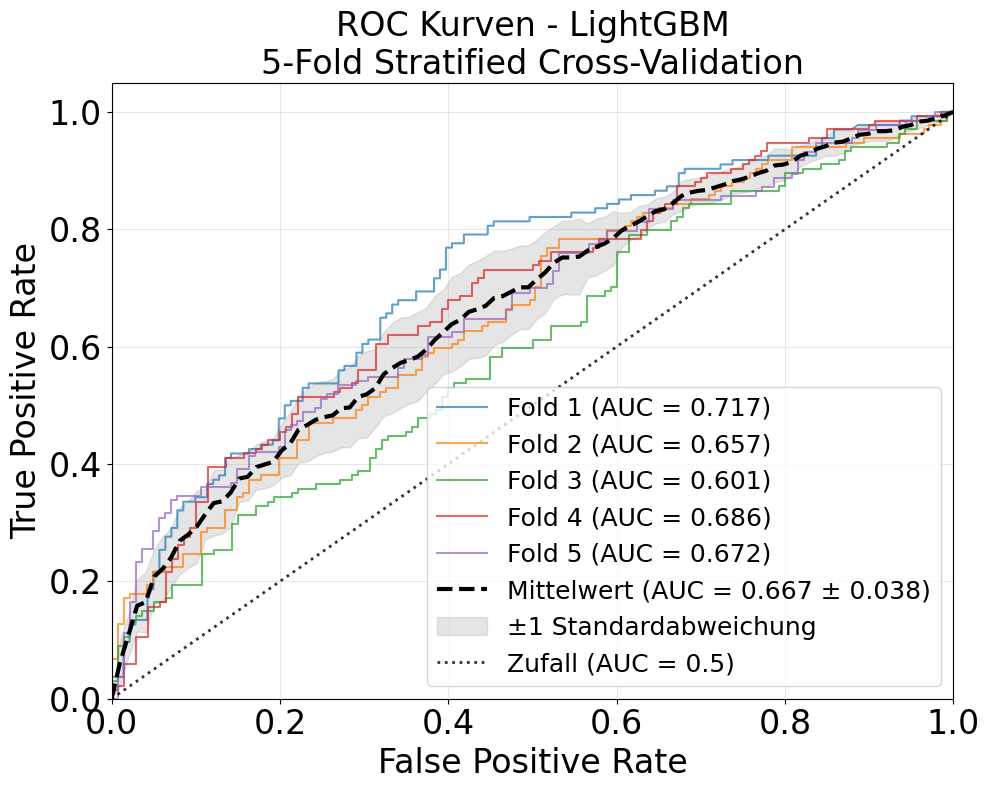


############################################################
ANALYSE: RandomForest
############################################################
Berechne ROC für RandomForest...
  Fold 1: AUC = 0.704
  Fold 2: AUC = 0.672
  Fold 3: AUC = 0.639
  Fold 4: AUC = 0.699
  Fold 5: AUC = 0.678
  RandomForest: Mittlere AUC = 0.678 ± 0.023
✅ Modell als 'trained_RandomForest' gespeichert.

STATISTIKEN FÜR RANDOMFOREST
Anzahl Folds: 5
Mittlere AUC: 0.6782
Standardabweichung: 0.0232
Minimum AUC: 0.6388
Maximum AUC: 0.7040
AUC-Bereich: 0.0653

AUC pro Fold:
  Fold 1: 0.7040
  Fold 2: 0.6716
  Fold 3: 0.6388
  Fold 4: 0.6989
  Fold 5: 0.6777


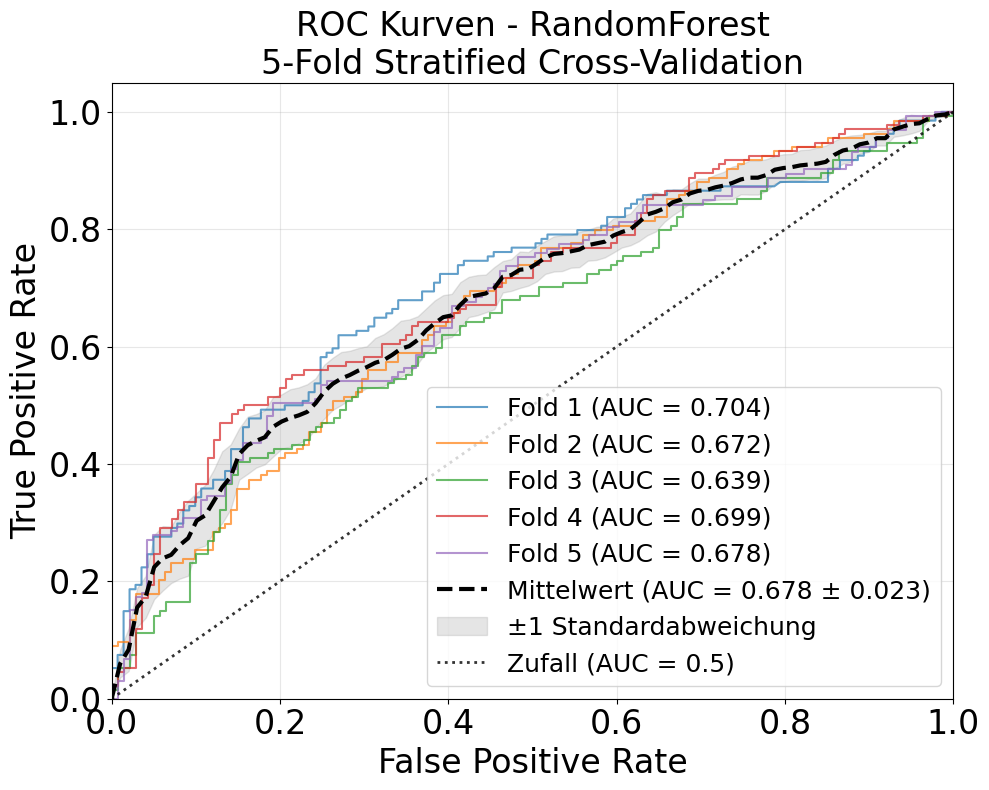


############################################################
ANALYSE: DecisionTree
############################################################
Berechne ROC für DecisionTree...
  Fold 1: AUC = 0.697
  Fold 2: AUC = 0.577
  Fold 3: AUC = 0.604
  Fold 4: AUC = 0.680
  Fold 5: AUC = 0.584
  DecisionTree: Mittlere AUC = 0.628 ± 0.050
✅ Modell als 'trained_DecisionTree' gespeichert.

STATISTIKEN FÜR DECISIONTREE
Anzahl Folds: 5
Mittlere AUC: 0.6284
Standardabweichung: 0.0502
Minimum AUC: 0.5766
Maximum AUC: 0.6970
AUC-Bereich: 0.1205

AUC pro Fold:
  Fold 1: 0.6970
  Fold 2: 0.5766
  Fold 3: 0.6042
  Fold 4: 0.6801
  Fold 5: 0.5841


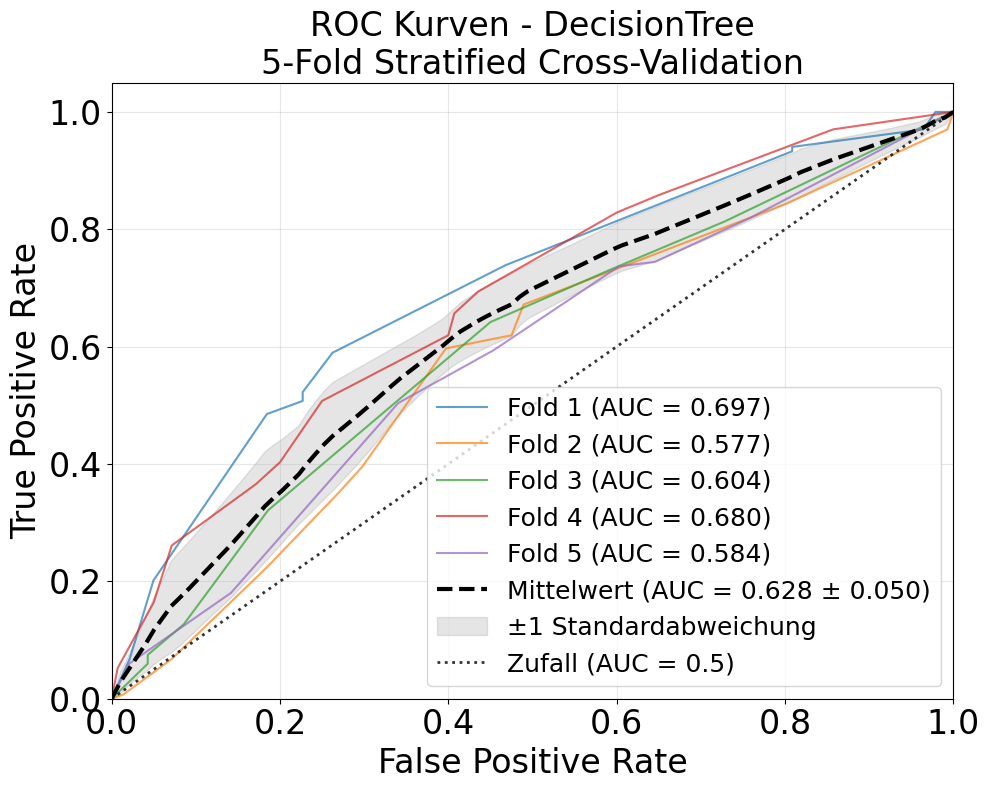


############################################################
ANALYSE: XGBoost
############################################################
Berechne ROC für XGBoost...


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

  Fold 1: AUC = 0.707


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:26:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

  Fold 2: AUC = 0.675


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

  Fold 3: AUC = 0.639


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:26:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

  Fold 4: AUC = 0.682


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:26:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

  Fold 5: AUC = 0.670
  XGBoost: Mittlere AUC = 0.675 ± 0.022


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[15:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[15:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\sauer\AppDa

✅ Modell als 'trained_XGBoost' gespeichert.

STATISTIKEN FÜR XGBOOST
Anzahl Folds: 5
Mittlere AUC: 0.6745
Standardabweichung: 0.0219
Minimum AUC: 0.6388
Maximum AUC: 0.7069
AUC-Bereich: 0.0681

AUC pro Fold:
  Fold 1: 0.7069
  Fold 2: 0.6752
  Fold 3: 0.6388
  Fold 4: 0.6816
  Fold 5: 0.6701


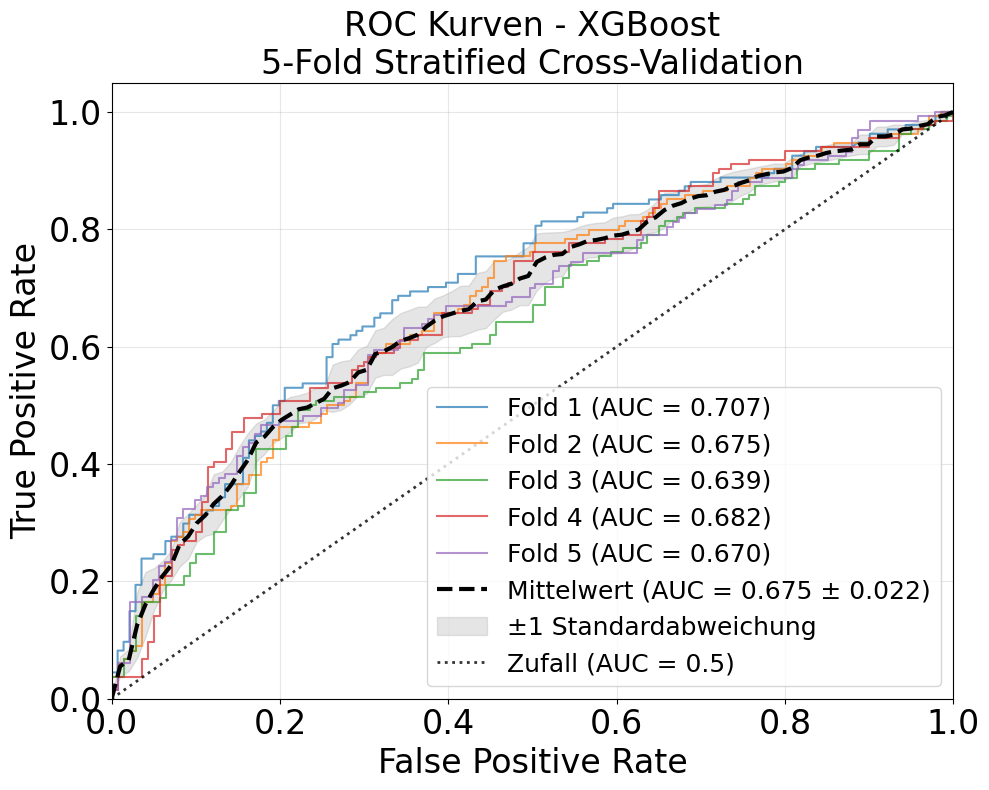


############################################################
ANALYSE: LogisticRegression
############################################################
Berechne ROC für LogisticRegression...
  Fold 1: AUC = 0.686
  Fold 2: AUC = 0.666
  Fold 3: AUC = 0.674
  Fold 4: AUC = 0.683
  Fold 5: AUC = 0.646
  LogisticRegression: Mittlere AUC = 0.671 ± 0.014
✅ Modell als 'trained_LogisticRegression' gespeichert.

STATISTIKEN FÜR LOGISTICREGRESSION
Anzahl Folds: 5
Mittlere AUC: 0.6710
Standardabweichung: 0.0141
Minimum AUC: 0.6462
Maximum AUC: 0.6856
AUC-Bereich: 0.0394

AUC pro Fold:
  Fold 1: 0.6856
  Fold 2: 0.6663
  Fold 3: 0.6743
  Fold 4: 0.6826
  Fold 5: 0.6462


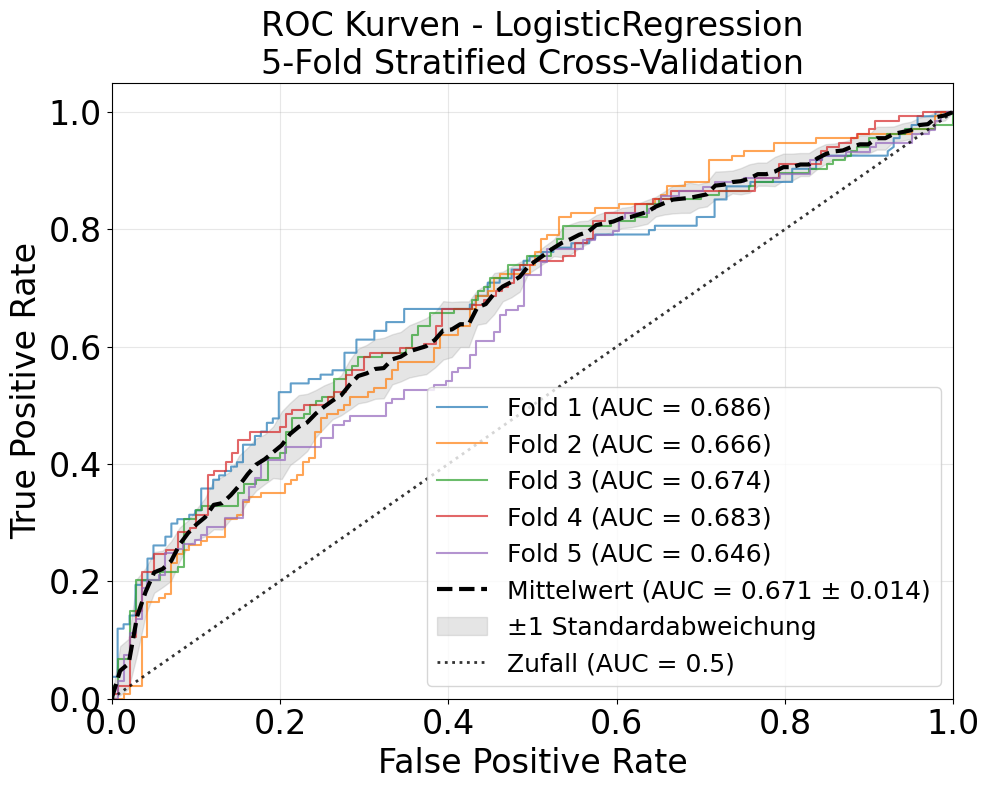


############################################################
ANALYSE: NeuralNetwork
############################################################
Berechne ROC für NeuralNetwork...
  Fold 1: AUC = 0.681
  Fold 2: AUC = 0.634
  Fold 3: AUC = 0.616
  Fold 4: AUC = 0.662
  Fold 5: AUC = 0.619
  NeuralNetwork: Mittlere AUC = 0.642 ± 0.025
✅ Modell als 'trained_NeuralNetwork' gespeichert.

STATISTIKEN FÜR NEURALNETWORK
Anzahl Folds: 5
Mittlere AUC: 0.6424
Standardabweichung: 0.0253
Minimum AUC: 0.6158
Maximum AUC: 0.6812
AUC-Bereich: 0.0654

AUC pro Fold:
  Fold 1: 0.6812
  Fold 2: 0.6341
  Fold 3: 0.6158
  Fold 4: 0.6620
  Fold 5: 0.6192


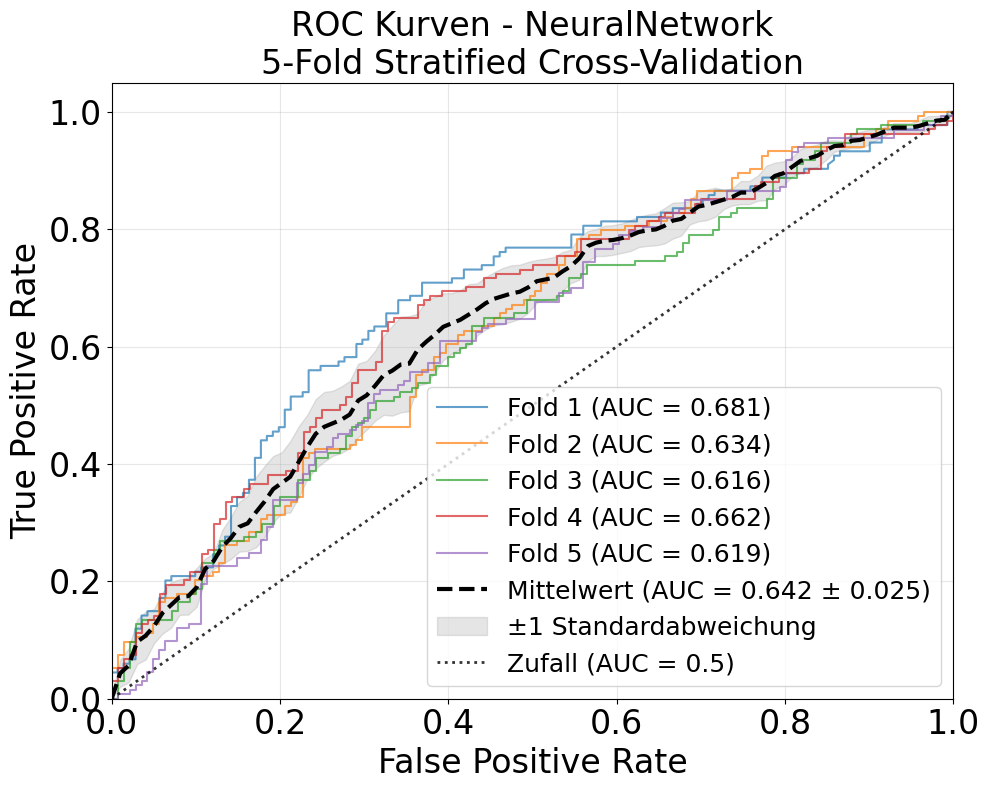

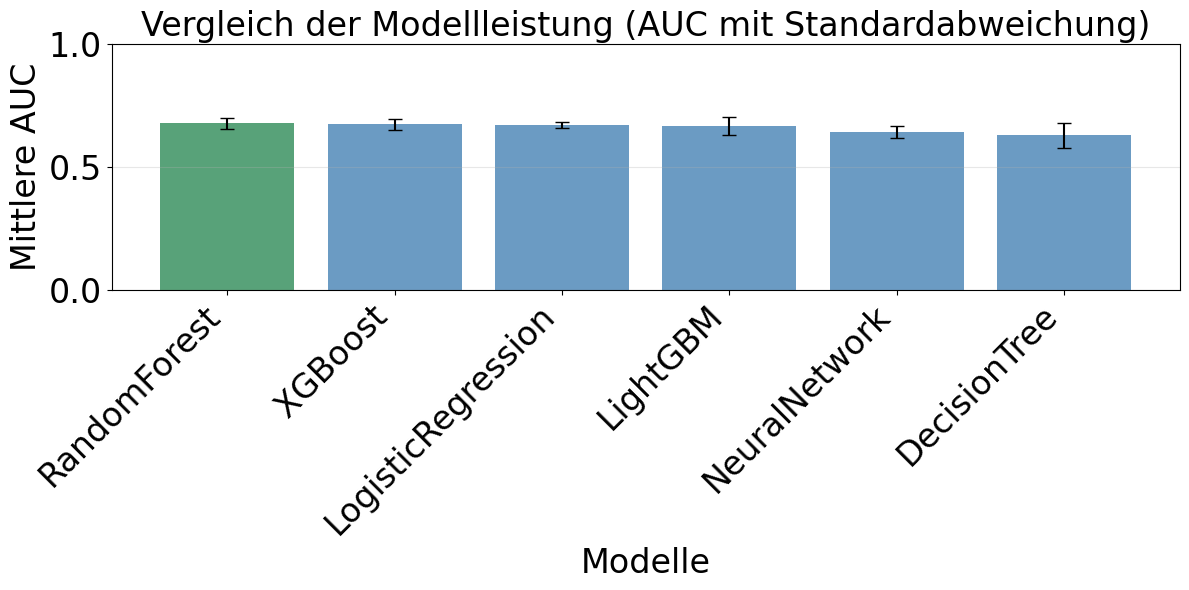


✅ ROC-Analyse abgeschlossen!


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


# --- Schriftgröße global festlegen ---
FONT_SIZE_LABEL = 24
FONT_SIZE_TITLE = 24
FONT_SIZE_LEGEND = 18
FONT_SIZE_TICKS = 24
FONT_SIZE_BAR_LABEL = 24


plt.rcParams.update({
    "axes.titlesize": FONT_SIZE_TITLE,
    "axes.labelsize": FONT_SIZE_LABEL,
    "xtick.labelsize": FONT_SIZE_TICKS,
    "ytick.labelsize": FONT_SIZE_TICKS,
    "legend.fontsize": FONT_SIZE_LEGEND
})

# --- 2) Modifizierte Modelltraining-Funktion für ROC ---
def train_model_with_proba(model_func, X_train, X_test, y_train, y_test):
    """
    Wrapper-Funktion um Modelle zu trainieren und Wahrscheinlichkeiten zu erhalten
    """
    try:
        # Erstelle temporären DataFrame für die Modellfunktion
        train_data = X_train.copy()
        train_data['Aktiv'] = y_train
        
        # Trainiere das Modell
        result = model_func(train_data)
        
        # Hole das trainierte Modell
        model = result.get('model', None)
        
        if model is None:
            return None, None
        
        # Spezielle Behandlung für XGBoost Booster
        if hasattr(model, 'predict') and hasattr(model, 'get_dump'):
            # Das ist ein XGBoost Booster (von xgb.train())
            import xgboost as xgb
            dtest = xgb.DMatrix(X_test)
            y_proba = model.predict(dtest)
        # Normale Behandlung für Sklearn-kompatible Modelle
        elif hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für positive Klasse
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test)
        else:
            # Fallback: verwende predict und normalisiere
            y_pred = model.predict(X_test)
            if len(np.unique(y_pred)) > 2:  # Kontinuierliche Werte
                y_proba = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
            else:  # Binäre Werte
                y_proba = y_pred
            
        return y_proba, result.get('metrics', {})
        
    except Exception as e:
        print(f"Fehler beim Training: {e}")
        return None, None

# --- 3) ROC Analyse mit Stratified K-Fold für einzelne Modelle ---
def compute_roc_curves_per_model(X, y, model_name, model_func, n_splits=5, random_state=42):
    """
    Berechnet ROC-Kurven für ein einzelnes Modell mit allen Folds
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    fold_results = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    print(f"Berechne ROC für {model_name}...")
    
    fold = 0
    for train_idx, test_idx in skf.split(X, y):
        fold += 1
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Trainiere Modell und erhalte Wahrscheinlichkeiten
        y_proba, metrics = train_model_with_proba(model_func, X_train, X_test, y_train, y_test)
        
        if y_proba is not None:
            # Berechne ROC
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            
            # Interpoliere auf gemeinsame FPR-Werte für Mittelwertberechnung
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            
            fold_results.append({
                'fold': fold,
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc
            })
            
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
            
            print(f"  Fold {fold}: AUC = {roc_auc:.3f}")
    
    # Berechne Mittelwerte
    if len(aucs) > 0:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
        
        print(f"  {model_name}: Mittlere AUC = {mean_auc:.3f} ± {std_auc:.3f}")
        
        return {
            'fold_results': fold_results,
            'mean_fpr': mean_fpr,
            'mean_tpr': mean_tpr,
            'std_tpr': std_tpr,
            'mean_auc': mean_auc,
            'std_auc': std_auc,
            'individual_aucs': aucs 
        }
    else:
        print(f"  Keine gültigen ROC-Daten für {model_name}")
        return None

# --- 4) Visualisierung der ROC-Kurven pro Modell ---
def plot_roc_curves_per_model(roc_results, model_name, figsize=(10, 8)):
    """
    Plottet ROC-Kurven für ein einzelnes Modell mit allen Folds
    """
    plt.figure(figsize=figsize)
    
    # Farben für die verschiedenen Folds
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plotte jeden Fold
    for i, fold_data in enumerate(roc_results['fold_results']):
        color = colors[i % len(colors)]
        plt.plot(fold_data['fpr'], fold_data['tpr'], 
                color=color, alpha=0.7, linewidth=1.5,
                label=f"Fold {fold_data['fold']} (AUC = {fold_data['auc']:.3f})")
    
    # Plotte mittlere ROC-Kurve
    plt.plot(roc_results['mean_fpr'], roc_results['mean_tpr'], 
            color='black', linewidth=3, linestyle='--',
            label=f"Mittelwert (AUC = {roc_results['mean_auc']:.3f} ± {roc_results['std_auc']:.3f})")
    
    # Füge Konfidenzintervall für Mittelwert hinzu
    tprs_upper = np.minimum(roc_results['mean_tpr'] + roc_results['std_tpr'], 1)
    tprs_lower = np.maximum(roc_results['mean_tpr'] - roc_results['std_tpr'], 0)
    
    plt.fill_between(roc_results['mean_fpr'], tprs_lower, tprs_upper, 
                    color='gray', alpha=0.2, label='±1 Standardabweichung')
    
    # Referenzlinie (zufällige Klassifikation)
    plt.plot([0, 1], [0, 1], 'k:', alpha=0.8, linewidth=2, label='Zufall (AUC = 0.5)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Kurven - {model_name}\n5-Fold Stratified Cross-Validation')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

# --- 5) Zusammenfassende Statistiken ---
def print_model_statistics(roc_results, model_name):
    """
    Gibt detaillierte Statistiken für ein Modell aus
    """
    print(f"\n{'='*50}")
    print(f"STATISTIKEN FÜR {model_name.upper()}")
    print(f"{'='*50}")
    
    aucs = roc_results['individual_aucs']
    
    print(f"Anzahl Folds: {len(aucs)}")
    print(f"Mittlere AUC: {roc_results['mean_auc']:.4f}")
    print(f"Standardabweichung: {roc_results['std_auc']:.4f}")
    print(f"Minimum AUC: {min(aucs):.4f}")
    print(f"Maximum AUC: {max(aucs):.4f}")
    print(f"AUC-Bereich: {max(aucs) - min(aucs):.4f}")
    
    print("\nAUC pro Fold:")
    for i, auc_val in enumerate(aucs, 1):
        print(f"  Fold {i}: {auc_val:.4f}")

# --- 6) Hauptanalyse ---
def run_roc_analysis():
    """
    Führt die vollständige ROC-Analyse durch
    Speichert die trainierten Modelle als Variablen mit Präfix 'trained_'
    """
    print("Starte ROC-Analyse mit df_encoded...")
    print("="*60)
    
    X = df_encoded.drop('Aktiv', axis=1)
    y = df_encoded['Aktiv']
    
    print(f"Dataset Shape: {X.shape}")
    print(f"Anzahl Features: {X.shape[1]}")
    print(f"Klassenverteilung:")
    print(y.value_counts())
    print()
    
    all_model_results = {}
    summary_results = []
    
    for model_name, model_func in models.items():
        print(f"\n{'#'*60}")
        print(f"ANALYSE: {model_name}")
        print(f"{'#'*60}")
        
        # Berechne ROC-Kurven
        roc_results = compute_roc_curves_per_model(X, y, model_name, model_func, n_splits=5)
        
        if roc_results is not None:
            # Speichere Ergebnisse
            all_model_results[model_name] = roc_results
            
            # Speichere trainiertes Modell global mit Präfix 'trained_'
            model = None
            try:
                # Trainiere einmal auf gesamten Datensatz für SHAP (nur einmal)
                train_data = X.copy()
                train_data['Aktiv'] = y
                model_result = model_func(train_data)
                model = model_result.get('model', None)
            except Exception as e:
                print(f"Fehler beim Speichern des Modells {model_name}: {e}")
            
            if model is not None:
                globals()[f"trained_{model_name}"] = model
                print(f"✅ Modell als 'trained_{model_name}' gespeichert.")
            else:
                print(f"❌ Modell {model_name} konnte nicht gespeichert werden!")
            
            # Zeige Statistiken
            print_model_statistics(roc_results, model_name)
            
            # Plotte ROC-Kurven
            plot_roc_curves_per_model(roc_results, model_name)
            
            # Sammle für Zusammenfassung
            summary_results.append({
                'Model': model_name,
                'Mean_AUC': roc_results['mean_auc'],
                'Std_AUC': roc_results['std_auc'],
                'Min_AUC': min(roc_results['individual_aucs']),
                'Max_AUC': max(roc_results['individual_aucs'])
            })
        else:
            print(f"Fehler bei der Analyse von {model_name}")
    
    # --- 7) Abschließender Vergleich ---
    if summary_results:
        summary_df = pd.DataFrame(summary_results)
        summary_df = summary_df.sort_values('Mean_AUC', ascending=False)
        
        # Vergleichsplot wie vorher
        plt.figure(figsize=(12, 6))
        x_pos = range(len(summary_df))
        plt.bar(x_pos, summary_df['Mean_AUC'], 
               yerr=summary_df['Std_AUC'], 
               capsize=5, alpha=0.8, 
               color=['#2E8B57' if i == 0 else '#4682B4' for i in range(len(summary_df))])
        plt.xticks(x_pos, summary_df['Model'], rotation=45, ha='right')
        plt.xlabel('Modelle')
        plt.ylabel('Mittlere AUC')
        plt.title('Vergleich der Modellleistung (AUC mit Standardabweichung)')
        plt.grid(True, alpha=0.3, axis='y')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
    
    return all_model_results

# --- 8) Starte die Analyse ---
print("ROC-Analyse wird gestartet...")
all_model_results = run_roc_analysis()
print("\n✅ ROC-Analyse abgeschlossen!")

Beste Parameter: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
Fold 1: SHAP Werte berechnet für 275 Samples
Fold 2: SHAP Werte berechnet für 275 Samples


100%|===================| 547/548 [00:12<00:00]        

Fold 3: SHAP Werte berechnet für 274 Samples
Fold 4: SHAP Werte berechnet für 274 Samples


 96%|=================== | 528/548 [00:11<00:00]       

Fold 5: SHAP Werte berechnet für 274 Samples


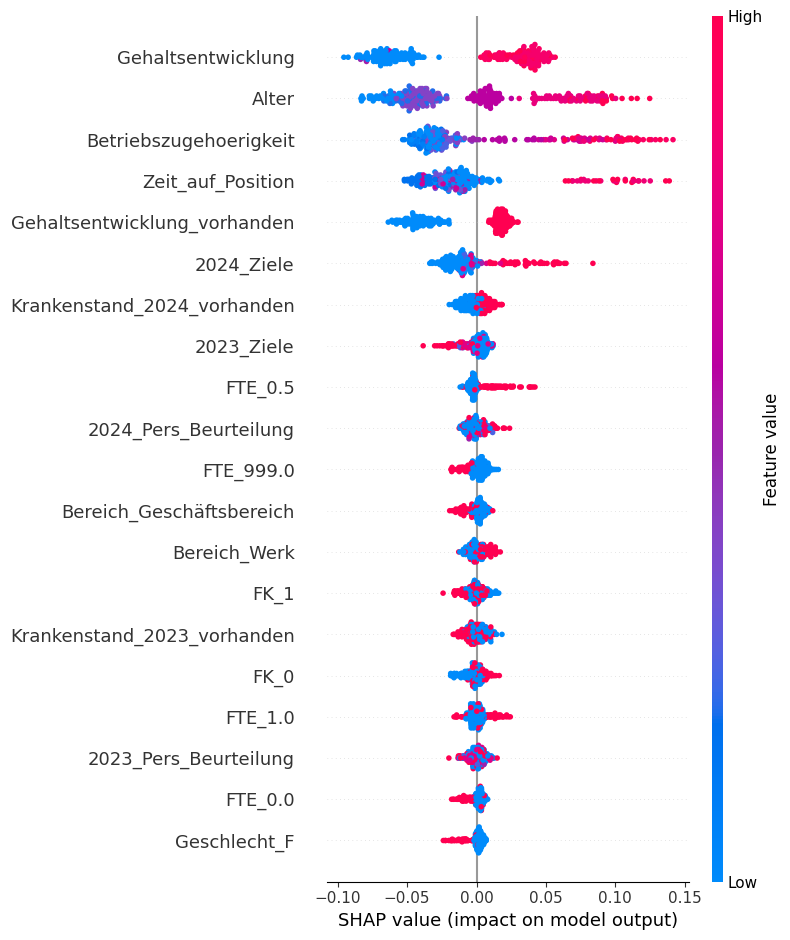

In [42]:
import shap
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# ---------------------------
# 1️⃣ Features und Ziel
# ---------------------------
X_rf = df_encoded.drop(columns=['Aktiv'], axis=1)
y_rf = df_encoded['Aktiv']

# ---------------------------
# 2️⃣ Stratified K-Fold für spätere SHAP-Analyse
# ---------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------
# 3️⃣ RandomizedSearchCV für Hyperparameter
# ---------------------------
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "max_features": ['sqrt', 'log2', None]
}

base_model = RandomForestClassifier(random_state=42)

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score),
    cv=skf,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

search.fit(X_rf, y_rf)
clf = search.best_estimator_
best_params = search.best_params_
print("Beste Parameter:", best_params)

# ---------------------------
# 4️⃣ SHAP Analyse auf Stratified K-Fold
# ---------------------------
shap_values_list = []
explainer_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_rf, y_rf), 1):
    X_train, X_test = X_rf.iloc[train_idx], X_rf.iloc[test_idx]
    y_train, y_test = y_rf.iloc[train_idx], y_rf.iloc[test_idx]

    # Trainiere Modell mit besten Parametern
    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap_values_list.append(shap_values)
    explainer_list.append(explainer)
    print(f"Fold {fold}: SHAP Werte berechnet für {X_test.shape[0]} Samples")

# ---------------------------
# 5️⃣ Beispiel: SHAP Summary für Klasse 1 aus Fold 1
# ---------------------------
shap_exp_class1 = shap.Explanation(
    values=shap_values_list[0].values[:, :, 1],
    base_values=explainer_list[0].expected_value[1],
    data=shap_values_list[0].data,
    feature_names=X_rf.columns.tolist()
)

shap.summary_plot(shap_exp_class1.values, X_rf.iloc[skf.split(X_rf, y_rf).__next__()[1], :])

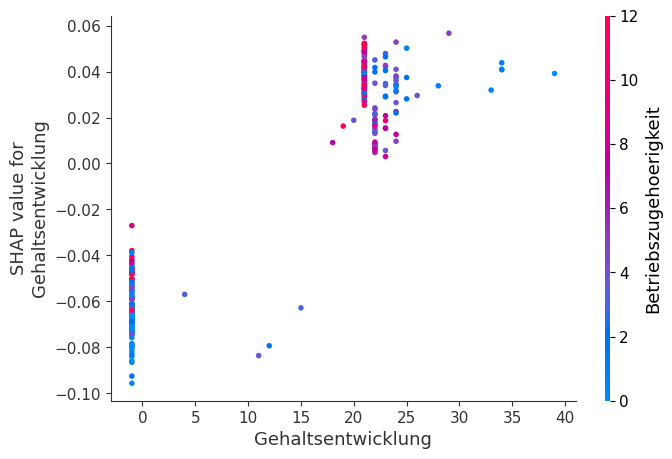

In [43]:
# Testdaten der ersten Fold
X_test_fold1 = X_rf.iloc[list(skf.split(X_rf, y_rf))[0][1], :]

# SHAP-Werte der ersten Fold, Klasse 1
shap_values_fold1_class1 = shap_values_list[0].values[:, :, 1]
# Dependence Plot
shap.dependence_plot(
    "Gehaltsentwicklung",                     # Feature-Name als String
    shap_values_fold1_class1,     # SHAP-Werte (n_samples, n_features)
    X_test_fold1,                 # Original-Feature DataFrame
    interaction_index="auto"      # Optional: stärkste Interaktion
)


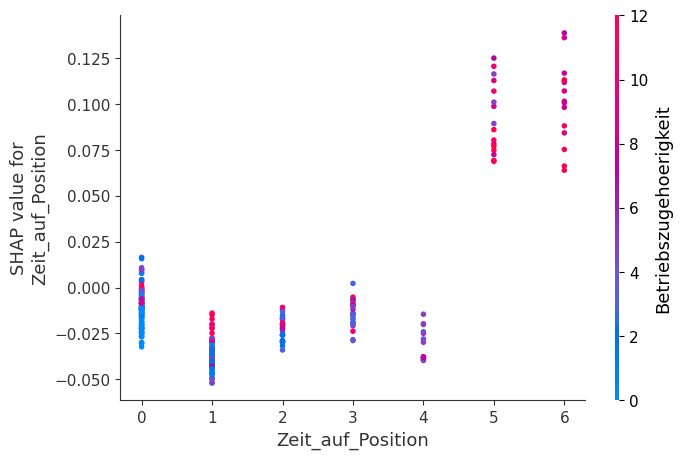

In [44]:
# Dependence Plot
shap.dependence_plot(
    "Zeit_auf_Position",                     # Feature-Name als String
    shap_values_fold1_class1,     # SHAP-Werte (n_samples, n_features)
    X_test_fold1,                 # Original-Feature DataFrame
    interaction_index="auto"      # Optional: stärkste Interaktion
)


<Figure size 800x600 with 0 Axes>

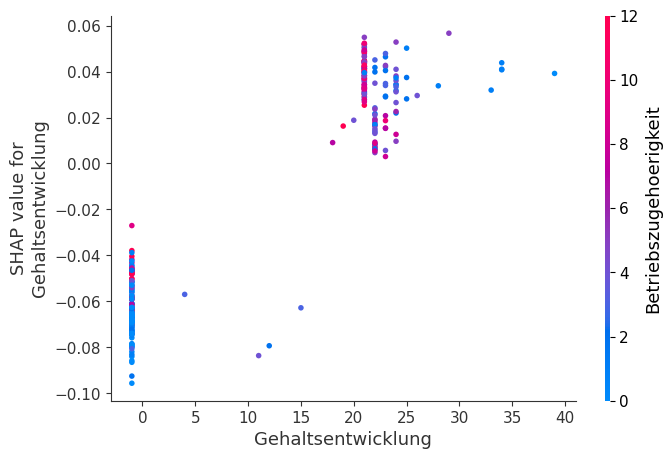

<Figure size 800x600 with 0 Axes>

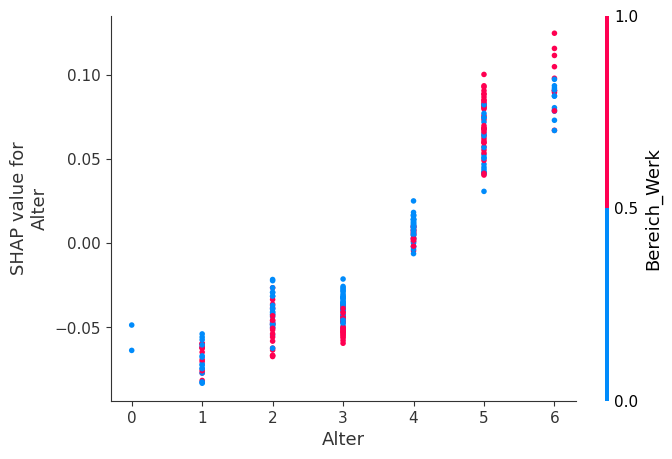

<Figure size 800x600 with 0 Axes>

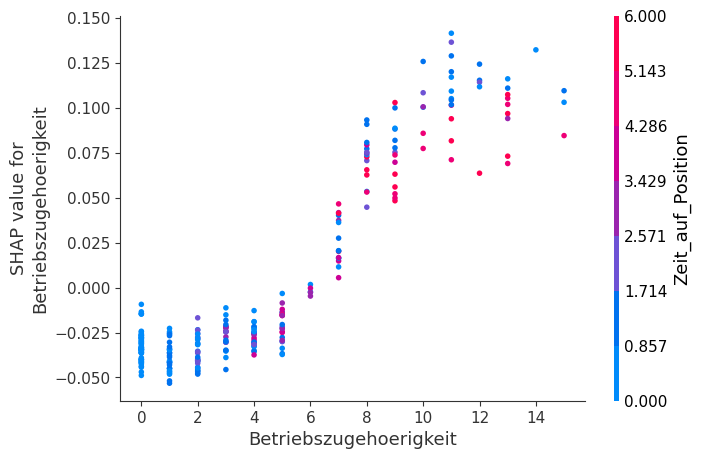

<Figure size 800x600 with 0 Axes>

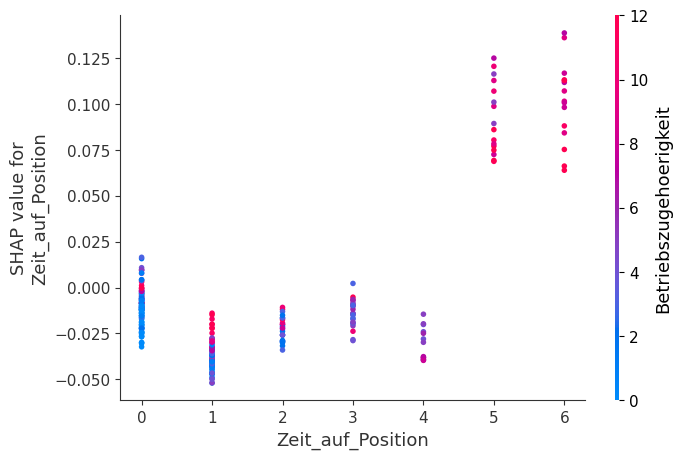

<Figure size 800x600 with 0 Axes>

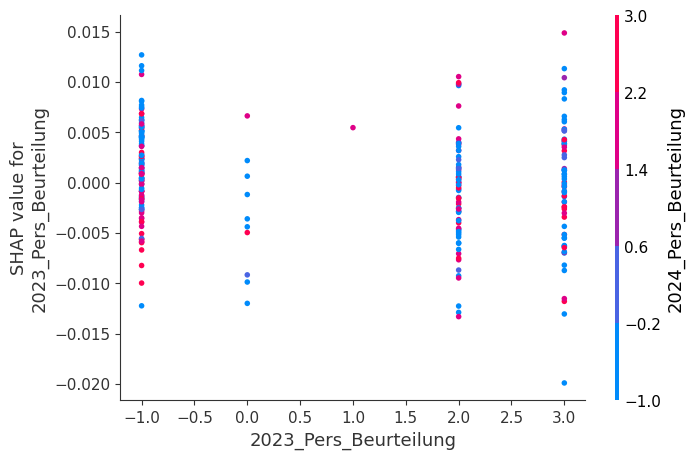

<Figure size 800x600 with 0 Axes>

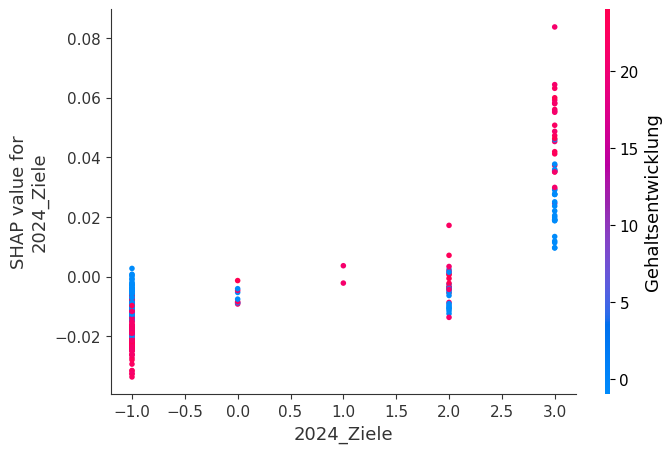

<Figure size 800x600 with 0 Axes>

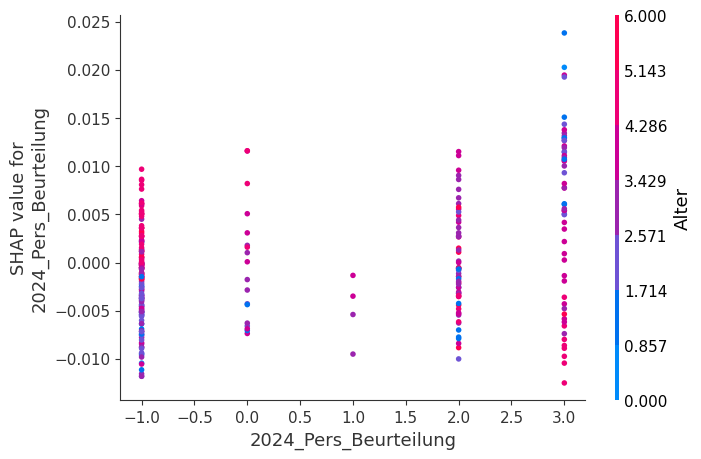

<Figure size 800x600 with 0 Axes>

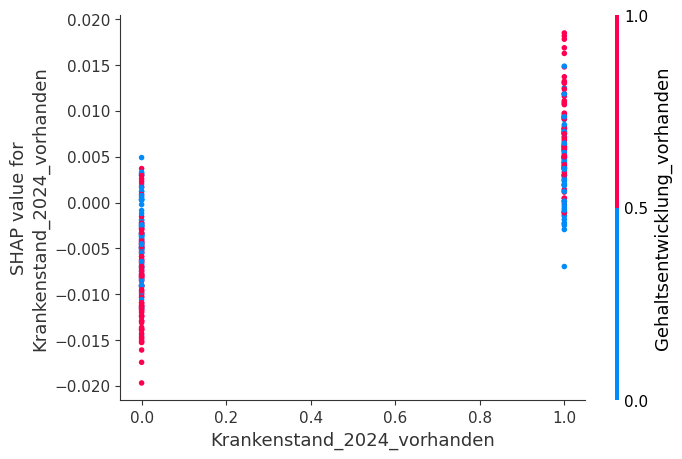

<Figure size 800x600 with 0 Axes>

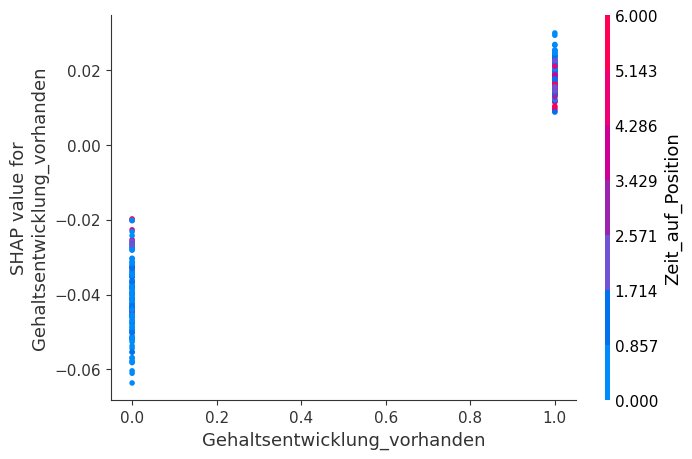

In [45]:
features_to_plot = ['Gehaltsentwicklung',
 'Alter',
 'Betriebszugehoerigkeit',
 'Zeit_auf_Position',
 '2023_Pers_Beurteilung',
 '2024_Ziele',
 '2024_Pers_Beurteilung',
 'Krankenstand_2024_vorhanden',
 'Gehaltsentwicklung_vorhanden']

# Schleife über die Features
for feat in features_to_plot:
    # Neue Figur erstellen
    plt.figure(figsize=(8,6))
    
    # Dependence Plot erstellen
    shap.dependence_plot(
        feat,
        shap_values_fold1_class1,
        X_test_fold1,
        interaction_index="auto",
    )
    plt.close()  # Figur schließen, um Speicher zu sparen

In [46]:
from sklearn.model_selection import StratifiedKFold

X = df_encoded.drop('Aktiv', axis=1)
y = df_encoded['Aktiv']

# StratifiedKFold initialisieren
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Nehmen wir einfach den ersten Fold als Beispiel
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    break  # nur den ersten Fold anschauen

# --- Anzeigen der Daten ---
print("=== Trainingsdaten ===")
print(X_train.head())
print(y_train.value_counts())  # Klassenverteilung im Training

print("\n=== Testdaten ===")
print(X_test.head())
print(y_test.value_counts())   # Klassenverteilung im Test

=== Trainingsdaten ===
   Alter  Betriebszugehoerigkeit  Zeit_auf_Position  2023_Ziele  \
0      4                       6                  6          -1   
1      1                       0                  0           1   
2      4                       9                  2          -1   
4      5                       5                  0           2   
5      3                       3                  3           2   

   2023_Pers_Beurteilung  2024_Ziele  2024_Pers_Beurteilung  \
0                      2          -1                     -1   
1                      2          -1                     -1   
2                      3          -1                     -1   
4                     -1          -1                     -1   
5                     -1          -1                      0   

   Krankenstand_2023  Krankenstand_2024  Gehaltsentwicklung  ...  \
0                 -1                  2                  21  ...   
1                  2                  2                  -1